In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/processed/sales_for_modelling.csv')

In [3]:
df.head()

,index,Value,Holiday,time,mdate,day,week,month,year
0,2013-11-07 13:00,34.57,NaN,13,7,3,45,11,2013
1,2013-11-07 14:00,22.50,NaN,14,7,3,45,11,2013
2,2013-11-07 15:00,0.00,NaN,15,7,3,45,11,2013
3,2013-11-07 16:00,7.29,NaN,16,7,3,45,11,2013
4,2013-11-07 17:00,0.00,NaN,17,7,3,45,11,2013


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39391 entries, 0 to 39390
Data columns (total 9 columns):
index      39391 non-null object
Value      39391 non-null float64
Holiday    1104 non-null object
time       39391 non-null int64
mdate      39391 non-null int64
day        39391 non-null int64
week       39391 non-null int64
month      39391 non-null int64
year       39391 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 2.7+ MB


In [5]:
df['index'] = pd.to_datetime(df['index'])

In [6]:
df.set_index('index', inplace = True)

In [7]:
df.isna().sum()

Value          0
Holiday    38287
time           0
mdate          0
day            0
week           0
month          0
year           0
dtype: int64

In [8]:
df.index.min()

Timestamp('2013-11-07 13:00:00')

In [9]:
df.index.max()

Timestamp('2018-05-06 19:00:00')

Again for this model we'll only be using sales for the time being as modelling with this type of data is already challenging.

In [10]:
# dropping all unnecessary columns
df.drop(['Holiday', 'time', 'mdate', 'day', 'week', 'month', 'year'], axis =1, inplace = True)




# Splitting into Training/Validation/Test

Moving forward we'll be using training and validation on the LSTM models while keeping the test set for the last final check on our winning model.

In [36]:
len(df)

39391

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
n_steps = 24 # 24 hours worth of hourly input to predict 1 future hour
reframed = series_to_supervised(scaled, n_steps, 1)

In [14]:
values =reframed.values

In [15]:
values

array([[0.47689336, 0.31038764, 0.        , ..., 0.75596634, 0.58339081,
        0.59497862],
       [0.31038764, 0.        , 0.1005656 , ..., 0.58339081, 0.59497862,
        0.58173541],
       [0.        , 0.1005656 , 0.        , ..., 0.59497862, 0.58173541,
        0.5555249 ],
       ...,
       [0.44433715, 0.49248172, 0.48530832, ..., 0.50282798, 0.46516761,
        0.42447234],
       [0.49248172, 0.48530832, 0.42571389, ..., 0.46516761, 0.42447234,
        0.4400607 ],
       [0.48530832, 0.42571389, 0.        , ..., 0.42447234, 0.4400607 ,
        0.1047041 ]])

In [16]:
n_train_time = 30000
train = values[:n_train_time, :]
test = values[n_train_time:, :]

In [17]:
test.shape

(9367, 25)

In [18]:
train.shape

(30000, 25)

In [19]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [20]:
n_features=1

In [21]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [22]:
test_X.shape

(9367, 24, 1)

In [23]:
train_X.shape

(30000, 24, 1)

In [24]:
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

In [25]:
model_1 = Sequential()
model_1.add (LSTM(100,input_shape=(train_X.shape[1], train_X.shape[2])))
model_1.add(Dense(1))

model_1.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Dropout(0.2))

# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')


In [28]:
# model.summary()

In [29]:
history = model_1.fit(train_X, train_y, 
                    epochs=10, batch_size=70, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Train on 30000 samples, validate on 9367 samples
Epoch 1/10
 - 13s - loss: 0.0120 - val_loss: 0.0080
Epoch 2/10
 - 13s - loss: 0.0075 - val_loss: 0.0064
Epoch 3/10
 - 13s - loss: 0.0061 - val_loss: 0.0055
Epoch 4/10
 - 13s - loss: 0.0056 - val_loss: 0.0053
Epoch 5/10
 - 13s - loss: 0.0054 - val_loss: 0.0054
Epoch 6/10
 - 13s - loss: 0.0054 - val_loss: 0.0049
Epoch 7/10
 - 13s - loss: 0.0051 - val_loss: 0.0053
Epoch 8/10
 - 14s - loss: 0.0053 - val_loss: 0.0052
Epoch 9/10
 - 13s - loss: 0.0053 - val_loss: 0.0049
Epoch 10/10
 - 13s - loss: 0.0051 - val_loss: 0.0048


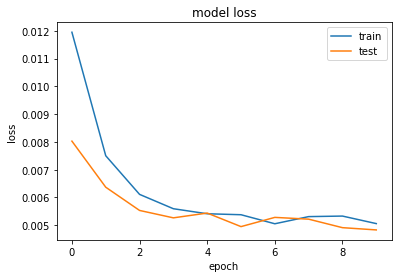

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Adding another LSTM layer and Dropouts

In [31]:
model_2 = Sequential()

model_2.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(70))
model_2.add(Dense(1))

model_2.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 120)           58560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 120)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                53480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 71        
Total params: 112,111
Trainable params: 112,111
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model_2.fit(train_X, train_y, 
                    epochs=10, batch_size=70, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Train on 30000 samples, validate on 9367 samples
Epoch 1/10
 - 33s - loss: 0.0127 - val_loss: 0.0088
Epoch 2/10
 - 31s - loss: 0.0078 - val_loss: 0.0067
Epoch 3/10
 - 33s - loss: 0.0063 - val_loss: 0.0057
Epoch 4/10
 - 35s - loss: 0.0057 - val_loss: 0.0052
Epoch 5/10
 - 35s - loss: 0.0052 - val_loss: 0.0048
Epoch 6/10
 - 36s - loss: 0.0050 - val_loss: 0.0046
Epoch 7/10
 - 33s - loss: 0.0049 - val_loss: 0.0046
Epoch 8/10
 - 37s - loss: 0.0048 - val_loss: 0.0045
Epoch 9/10
 - 33s - loss: 0.0048 - val_loss: 0.0044
Epoch 10/10
 - 35s - loss: 0.0046 - val_loss: 0.0044


In [34]:
# make a prediction
yhat = model.predict(test_X)
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 24))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'model' is not defined

In [ ]:
fig = plt.subplots()
aa=[x for x in range(300)]
plt.plot(aa, inv_y[:300], marker='.', label="actual")
plt.plot(aa, inv_yhat[:300], 'r', label="prediction")
plt.ylabel('Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show()

#  Splitting Test-Train

In [ ]:
# # Set train/test time split
# train_start  = pd.to_datetime('2017120100', format='%Y%m%d%H', errors='ignore') 
# train_end    = pd.to_datetime('2018033023', format='%Y%m%d%H', errors='ignore')
# test_start   = train_end  + pd.Timedelta(hours=1)
# test_end     = pd.to_datetime('2018050619', format='%Y%m%d%H', errors='ignore')

In [ ]:
# # Assign train/test data frames

# df_train = df.loc[train_start:train_end]
# df_test  = df.loc[test_start:]
# print('Test/train ratio: {r}'.format(r=round(len(df_test)/(len(df_train)+len(df_test)),2)))

In [ ]:
# df_train.drop(['Holiday', 'time', 'mdate', 'day', 'week', 'month', 'year'],axis =1, inplace = True)

In [ ]:
# df_test.drop(['Holiday', 'time', 'mdate', 'day', 'week', 'month', 'year'],axis =1, inplace = True)

In [ ]:
# # Function to split time series data into:
# #   n consecutive time steps of data as X
# #   and 1 time step of data as y

# import numpy as np
# def split_data(data, n_steps):
#     X, y = list(), list()
#     for i in range(len(data)):
#         # index of last element for each grouping of steps
#         end_ix = i + n_steps
#     # break condition at the end of the sequence
#         if end_ix > len(data)-1:
#             break
#         # X = first n elements, y = the element after
#         seq_x, seq_y = data[i:end_ix], data[end_ix]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

In [ ]:
len(df_train)

In [ ]:
# # Assign number of time steps & epochs
# # n_steps = n sequence of X in time series followed by one Y
# n_steps    = 24*7*4 # 4 weeks worth of hourly input to predict 1 future hour
# batch_size = 24*7
# epochs     = 10
# n_features = 1


In [ ]:
# # Reshape X from [samples, steps] into [samples, steps, features]
# # as the required Keras input format

# X_train, y_train = split_data(df_train, n_steps)
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# X_test, y_test = split_data(df_test, n_steps)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframed = series_to_supervised(df_train, 24, 1)

In [ ]:
reframed